In [1]:
from keras.datasets import mnist
import numpy as np
from keras.layers import Input, Dense, Flatten, Reshape, Activation, concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization,Conv2DTranspose
from keras.models import Model
import keras.backend as K
from keras.layers import Lambda
import glob, os
import keras
from keras.preprocessing.image import ImageDataGenerator
import cv2
from tqdm import tqdm
import pandas as pd

import gc

base_dir = 'Selfie-dataset/images' 
batch_size = 128

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Selfie-dataset/selfie_dataset.csv')
df = df[(df.partial_faces == 0) & (df.baby == 0) & (df.child == 0)]
images = []
for i in tqdm(range(int(df['image_name'].shape[0]/2))):
    file = df['image_name'].iloc[i]
    img = cv2.imread(base_dir+'/'+file+'.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (32,32)) / 255
    images.append(img)
images = np.array(images)
#gc.collect()

100%|███████████████████████████████████████████████████████████████████████████| 18040/18040 [00:20<00:00, 899.96it/s]


In [46]:
def create_deep_conv_ae():
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Activation('sigmoid')(x)
    
    model = Model(inputs=[input_img], outputs=[decoded])
    
    model.summary()
    
    return encoded, decoded, model

In [47]:
def create_denoising_model(autoencoder):
    def add_noise(x):
        noise_factor = 0.1
        x = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.get_shape()) 
        x = K.clip(x, 0., 1.)
        #noise_factor = 0.5
        #x = x + K.random_normal(x.get_shape(), 0.5, noise_factor)
        #x = K.clip(x, 0., 1.)
        return x

    input_img  = Input(batch_shape=(batch_size, 32, 32, 3))
    noised_img = Lambda(add_noise)(input_img)

    noiser = Model(input_img, noised_img, name="noiser")
    denoiser_model = Model(input_img, autoencoder(noiser(input_img)), name="denoiser")
    return noiser, denoiser_model

In [48]:
c_encoder, c_decoder, c_autoencoder = create_deep_conv_ae()

noiser, denoiser_model = create_denoising_model(c_autoencoder)
denoiser_model.compile(optimizer='adam', loss='binary_crossentropy')

#c_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
denoiser_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_30 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_30 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_31 (Batc (None, 16, 16, 32)        128       
__________

In [49]:
denoiser_model.fit(images[:-(images.shape[0]%batch_size)],images[:-(images.shape[0]%batch_size)],
                epochs=20, batch_size=batch_size)

Epoch 1/20
17920/17920 [==============================] - ETA: 4:09 - loss: 0.799 - ETA: 1:02 - loss: 0.700 - ETA: 36s - loss: 0.656 - ETA: 25s - loss: 0.63 - ETA: 19s - loss: 0.61 - ETA: 16s - loss: 0.60 - ETA: 13s - loss: 0.59 - ETA: 11s - loss: 0.59 - ETA: 10s - loss: 0.58 - ETA: 9s - loss: 0.5843 - ETA: 8s - loss: 0.581 - ETA: 7s - loss: 0.577 - ETA: 6s - loss: 0.575 - ETA: 6s - loss: 0.573 - ETA: 5s - loss: 0.571 - ETA: 5s - loss: 0.569 - ETA: 4s - loss: 0.568 - ETA: 4s - loss: 0.566 - ETA: 4s - loss: 0.565 - ETA: 3s - loss: 0.563 - ETA: 3s - loss: 0.562 - ETA: 3s - loss: 0.561 - ETA: 3s - loss: 0.560 - ETA: 3s - loss: 0.559 - ETA: 2s - loss: 0.558 - ETA: 2s - loss: 0.557 - ETA: 2s - loss: 0.556 - ETA: 2s - loss: 0.556 - ETA: 2s - loss: 0.555 - ETA: 1s - loss: 0.554 - ETA: 1s - loss: 0.554 - ETA: 1s - loss: 0.553 - ETA: 1s - loss: 0.552 - ETA: 1s - loss: 0.551 - ETA: 1s - loss: 0.551 - ETA: 1s - loss: 0.550 - ETA: 1s - loss: 0.550 - ETA: 0s - loss: 0.549 - ETA: 0s - loss: 0.549 - 

17920/17920 [==============================] - ETA: 2s - loss: 0.500 - ETA: 2s - loss: 0.501 - ETA: 2s - loss: 0.501 - ETA: 2s - loss: 0.502 - ETA: 2s - loss: 0.501 - ETA: 2s - loss: 0.500 - ETA: 2s - loss: 0.500 - ETA: 2s - loss: 0.499 - ETA: 2s - loss: 0.499 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.497 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.498 - ETA: 1s - loss: 0.498 - ETA: 0s - loss: 0.498 - ETA: 0s - loss: 0.498 - ETA: 0s - loss: 0.498 - ETA: 0s - loss: 0.498 - ETA: 0s - loss: 0.498 - ETA: 0s - loss: 0.498 - ETA: 0s - loss: 0.498 - ETA: 0s - loss: 0.498 - ETA: 0s - loss: 0.498 - ETA: 0s - loss: 0.498 - ETA: 0s - loss: 0.498 - ETA: 0s - loss: 0

17920/17920 [==============================] - ETA: 2s - loss: 0.510 - ETA: 2s - loss: 0.493 - ETA: 2s - loss: 0.494 - ETA: 2s - loss: 0.492 - ETA: 2s - loss: 0.492 - ETA: 2s - loss: 0.491 - ETA: 2s - loss: 0.491 - ETA: 2s - loss: 0.492 - ETA: 2s - loss: 0.493 - ETA: 2s - loss: 0.492 - ETA: 1s - loss: 0.493 - ETA: 1s - loss: 0.493 - ETA: 1s - loss: 0.492 - ETA: 1s - loss: 0.492 - ETA: 1s - loss: 0.492 - ETA: 1s - loss: 0.492 - ETA: 1s - loss: 0.492 - ETA: 1s - loss: 0.491 - ETA: 1s - loss: 0.491 - ETA: 1s - loss: 0.491 - ETA: 1s - loss: 0.491 - ETA: 1s - loss: 0.491 - ETA: 1s - loss: 0.491 - ETA: 1s - loss: 0.491 - ETA: 1s - loss: 0.491 - ETA: 1s - loss: 0.491 - ETA: 1s - loss: 0.491 - ETA: 1s - loss: 0.491 - ETA: 0s - loss: 0.491 - ETA: 0s - loss: 0.491 - ETA: 0s - loss: 0.492 - ETA: 0s - loss: 0.492 - ETA: 0s - loss: 0.491 - ETA: 0s - loss: 0.491 - ETA: 0s - loss: 0.491 - ETA: 0s - loss: 0.492 - ETA: 0s - loss: 0.491 - ETA: 0s - loss: 0.492 - ETA: 0s - loss: 0.492 - ETA: 0s - loss: 0

17920/17920 [==============================] - ETA: 2s - loss: 0.477 - ETA: 2s - loss: 0.488 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.490 - ETA: 2s - loss: 0.490 - ETA: 2s - loss: 0.489 - ETA: 2s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 1s - loss: 0.489 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0

In [50]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [51]:
n = 10

imgs = images[:n]
encoded_imgs = c_autoencoder.predict(imgs, batch_size=n)
encoded_imgs[0]

array([[[0.3164868 , 0.3056831 , 0.2860652 ],
        [0.27005476, 0.29184172, 0.27525598],
        [0.32570034, 0.33837858, 0.29411587],
        ...,
        [0.45183414, 0.47904858, 0.4049577 ],
        [0.4496739 , 0.48182103, 0.4121241 ],
        [0.47016063, 0.47331482, 0.41487917]],

       [[0.30630702, 0.3152803 , 0.29045373],
        [0.28718337, 0.32456213, 0.27427772],
        [0.3150052 , 0.35412443, 0.29243428],
        ...,
        [0.4346618 , 0.5110032 , 0.39941028],
        [0.46489173, 0.5455781 , 0.4224967 ],
        [0.45866624, 0.49804702, 0.41362265]],

       [[0.4127309 , 0.41004625, 0.34733245],
        [0.39999595, 0.4166755 , 0.34338787],
        [0.3918999 , 0.40627033, 0.34477305],
        ...,
        [0.51701427, 0.57979566, 0.4628559 ],
        [0.5320431 , 0.61035687, 0.476455  ],
        [0.5021255 , 0.5500557 , 0.44794756]],

       ...,

       [[0.5634572 , 0.572269  , 0.48090154],
        [0.67386025, 0.6984821 , 0.5680824 ],
        [0.6245351 , 0

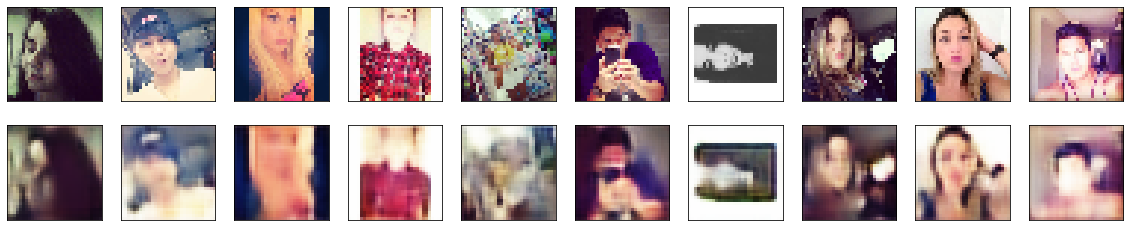

In [52]:
decoded_imgs = c_autoencoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

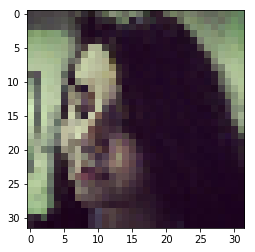

In [53]:
plt.imshow(images[0])